## Naive Bayes Classifier 

This notebook contains the naive bayes classifier on the collected data.

Table of Content:
* **1. Import required packages**
* **2. Import files**
* **3. Check the imbalance in the target feature**
* 3.1 Undersampling the majority class
* **4. Word Frequency**
* 4.1 Bag of Words
* 4.2 TF-IDF
* **5. Naive Bayes Classifier**
* 5.1 Define the target and explanatory variable, cross validation
* 5.2 Build the model with Sklearn pipeline
* 5.3 Evaluation of the model 
* *5.3.1 Modell Accuracy*
* *5.3.2 Confusion Matrix*
* *5.3.3 ROC curve*

### 1. Import required packages

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### 2. Import files

In [2]:
abt_covid = pd.read_pickle('C:/Users/molna/Desktop/Szakdolgozat/adatok/abt_covid_featured.pkl')

print("ABT table has {} rows and {} columns".format(len(abt_covid), len(abt_covid.columns)))

ABT table has 63633 rows and 50 columns


In [158]:
# select only the relevant features for the modelling
data = abt_covid[["dezinf", "title_lemmas", "text_lemmas"]]

### 3. Check the imbalance in the target feature

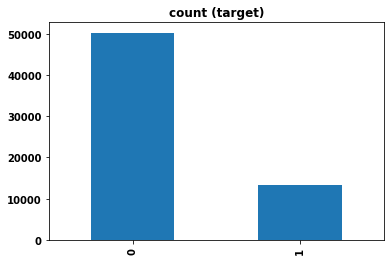

In [159]:
data['dezinf'].value_counts().plot(kind='bar', title='count (target)')

### 3.1 Undersampling the majority class

In [160]:
class_count_0, class_count_1 = data['dezinf'].value_counts()

In [161]:
class_0 = data[data['dezinf'] == 0]
class_1 = data[data['dezinf'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (50358, 3)
class 1: (13275, 3)


total class of 1 and0: 1    13275
0    13275
Name: dezinf, dtype: int64


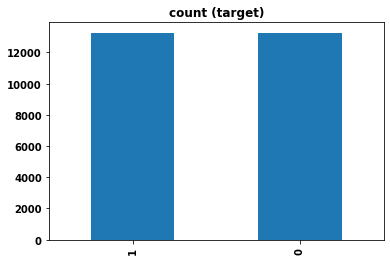

In [162]:
class_0_under = class_0.sample(class_count_1)

data_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and0:",test_under['dezinf'].value_counts())
data_under['dezinf'].value_counts().plot(kind='bar', title='count (target)')

In [139]:
data = data_under

### 4. Word Frequency

In [163]:
def dummy(doc):
    return doc

#### 4.1 Bag of Words

In [178]:
count_vect = CountVectorizer(tokenizer=dummy, preprocessor=dummy,)

In [179]:
word_count_matrix = count_vect.fit_transform(data_under["text_lemmas"])

In [180]:
word_count_matrix

<26550x192940 sparse matrix of type '<class 'numpy.int64'>'
	with 3906052 stored elements in Compressed Sparse Row format>

#### 4.2 TF-IDF
(i.e Term Frequency times inverse document frequency)

In [181]:
tf_idf = TfidfTransformer()
tf_idf.fit(word_count_matrix)
tf_idf.idf_

array([ 9.80052833,  6.93832745,  8.98959811, ..., 10.49367551,
       10.49367551, 10.49367551])

In [182]:
idf = pd.DataFrame(tf_idf.idf_, index=count_vect.get_feature_names(), columns=['idf_weight'])
idf.sort_values(by='idf_weight')

,idf_weight
koronavírus,1.289202
járvány,1.504980
ember,1.890488
tud,1.931891
ország,2.053579
...,...
kiutazta,10.493676
kiutazott,10.493676
kiutazon,10.493676
kivezényeljék,10.493676


### 5. Naive Bayes Classifier

#### 5.1 Define the target and explanatory variable, cross validation

In [183]:
X = data_under['text_lemmas']
y = data_under['dezinf']

In [184]:
# split data into 80% training and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 5.2 Build the model with Sklearn pipeline

In [185]:
pipe = Pipeline([
    ('vector', CountVectorizer(tokenizer=dummy, preprocessor=dummy)), 
    ('tfidf', TfidfTransformer()), 
    ('mulNB', MultinomialNB(alpha=0.4))
])

In [186]:
bayes_model = pipe.fit(X_train, y_train)

#### 5.3 Evaluation of the model

#### 5.3.1 Modell Accuracy

In [187]:
predicted = bayes_model.predict(X_test)

score = round(pipe.score(X_test, y_test), 2)

print("The Accuracy of the naive bayes model on the article text is: {} % with the balanced dataset".format(score))

The Accuracy of the naive bayes model on the article text is: 0.84 % with the balanced dataset


**The Accuracy of the naive bayes modell on the article text is 0.82% with the unbalances dataset.** 

#### 5.3.2 Confusion Matrix

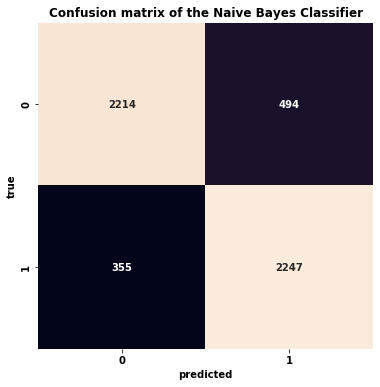

Failure first row (%):  22.31 %
Failure second row (%):  15.8 %


In [194]:
cm = confusion_matrix(y_test, predicted)
plt.figure(figsize = (6,6))
sns.heatmap(cm, annot=True, cbar=False, fmt="g")
plt.title('Confusion matrix of the Naive Bayes Classifier')
plt.xlabel("predicted")
plt.ylabel("true")

plt.show()

print("Failure first row (%): ", round(confusion_matrix(y_test, predicted)[0,1]/confusion_matrix(y_test, predicted)[0,0]*100,2),"%")
print("Failure second row (%): ", round(confusion_matrix(y_test, predicted)[1,0]/confusion_matrix(y_test, predicted)[1,1]*100,2),"%")

The model classifies the 77,69% of the mainstream articles in the good place.
And 84,2 % of the dezinformational articles in the good place.

#### 5.3.3 ROC curve

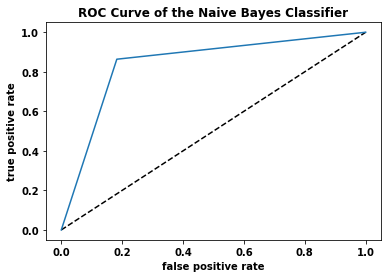

The AUC score of the Naive Bayes Classifier: 0.84


In [195]:
fpr, tpr, thresholds = roc_curve(y_test, predicted)

# plot the diagonal line
plt.plot([0,1],[0,1],'k--') 
# plot the ROC curve
plt.plot(fpr, tpr, label='NB') 
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC Curve of the Naive Bayes Classifier')
plt.show()

print("The AUC score of the Naive Bayes Classifier: {}".format(round(roc_auc_score(y_test, predicted), 2)))

In [196]:
prediction = pipe.predict(data_under['text_lemmas'])

In [197]:
data_under["prediction"] = prediction

In [198]:
data_under.head()

,dezinf,title_lemmas,text_lemmas,prediction
"""33417""",0,"[szlovákia, bocsánat, kér, zsidó, állampolgár,...","[szlovák, kormány, bocsánat, kér, szerda, holo...",0
"""34330""",0,"[milan, koronavírusos, rangadó]","[juventus, ac, milan, hiányzó, koronavírus, já...",0
"""12114""",0,"[gyógyszerész, kap, bruttó, forintos, juttatás]","[magyar, gyógyszerészi, kamara, elnök, közlemé...",0
"""39202""",0,"[astrazenec, vakcina, érkezik, magyarország]","[február, csütörtök, megérkezik, haza, astraze...",1
"""2103""",0,"[eddigi, komoly, helytállás, tanúsít, rendvéde...","[eddigi, komoly, helytállás, tanúsítaniu, rend...",0
